In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.full((size,1),0.85)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.full((size,1),0.1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:39,  2.96it/s]


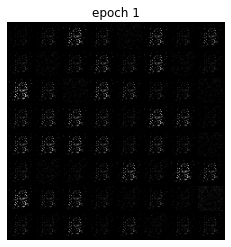

Epoch 1 of 100
Generator loss: 1.50875254, Discriminator loss: 1.05437752


118it [00:33,  3.54it/s]


Epoch 2 of 100
Generator loss: 1.49479270, Discriminator loss: 1.08338797


118it [00:35,  3.37it/s]


Epoch 3 of 100
Generator loss: 1.58512175, Discriminator loss: 1.23039102


118it [00:34,  3.41it/s]


Epoch 4 of 100
Generator loss: 1.95076033, Discriminator loss: 1.13393712


118it [00:34,  3.47it/s]


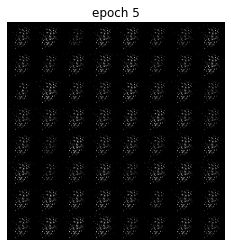

Epoch 5 of 100
Generator loss: 1.50444610, Discriminator loss: 1.19389494


118it [00:32,  3.58it/s]


Epoch 6 of 100
Generator loss: 1.45896217, Discriminator loss: 1.23312433


118it [00:34,  3.47it/s]


Epoch 7 of 100
Generator loss: 1.46804440, Discriminator loss: 1.29752904


118it [00:33,  3.57it/s]


Epoch 8 of 100
Generator loss: 1.29008325, Discriminator loss: 1.17977570


118it [00:33,  3.47it/s]


Epoch 9 of 100
Generator loss: 1.25336147, Discriminator loss: 1.32693256


118it [00:33,  3.54it/s]


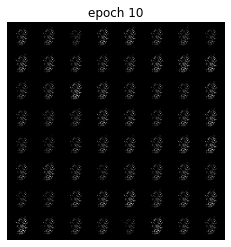

Epoch 10 of 100
Generator loss: 1.26864832, Discriminator loss: 1.37012698


118it [00:34,  3.37it/s]


Epoch 11 of 100
Generator loss: 1.47613828, Discriminator loss: 1.20170807


118it [00:33,  3.47it/s]


Epoch 12 of 100
Generator loss: 0.93541022, Discriminator loss: 1.22863873


118it [00:34,  3.46it/s]


Epoch 13 of 100
Generator loss: 0.97857153, Discriminator loss: 1.34954230


118it [00:33,  3.57it/s]


Epoch 14 of 100
Generator loss: 0.99560829, Discriminator loss: 1.26136074


118it [00:34,  3.46it/s]


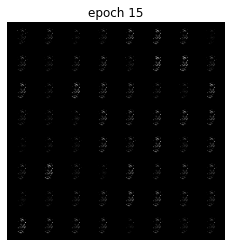

Epoch 15 of 100
Generator loss: 1.60927666, Discriminator loss: 1.19390658


118it [00:34,  3.46it/s]


Epoch 16 of 100
Generator loss: 0.99854970, Discriminator loss: 1.26580999


118it [00:32,  3.59it/s]


Epoch 17 of 100
Generator loss: 1.20646556, Discriminator loss: 1.20980339


118it [00:33,  3.47it/s]


Epoch 18 of 100
Generator loss: 1.18682943, Discriminator loss: 1.21456169


118it [00:33,  3.50it/s]


Epoch 19 of 100
Generator loss: 1.27479320, Discriminator loss: 1.09264088


118it [00:35,  3.35it/s]


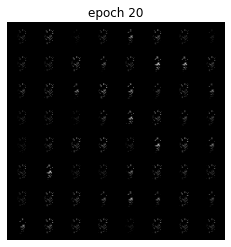

Epoch 20 of 100
Generator loss: 1.37451248, Discriminator loss: 1.11356583


118it [00:33,  3.53it/s]


Epoch 21 of 100
Generator loss: 1.32039638, Discriminator loss: 1.03802176


118it [00:34,  3.43it/s]


Epoch 22 of 100
Generator loss: 1.49523888, Discriminator loss: 1.03460580


118it [00:33,  3.48it/s]


Epoch 23 of 100
Generator loss: 1.58301835, Discriminator loss: 0.98324114


118it [00:34,  3.44it/s]


Epoch 24 of 100
Generator loss: 1.64634107, Discriminator loss: 0.99754175


118it [00:33,  3.50it/s]


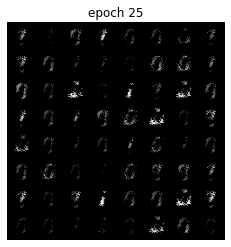

Epoch 25 of 100
Generator loss: 1.62253144, Discriminator loss: 1.00684240


118it [00:34,  3.41it/s]


Epoch 26 of 100
Generator loss: 1.55164563, Discriminator loss: 1.01494573


118it [00:34,  3.43it/s]


Epoch 27 of 100
Generator loss: 1.67426533, Discriminator loss: 0.98664647


118it [00:35,  3.35it/s]


Epoch 28 of 100
Generator loss: 1.48032130, Discriminator loss: 1.05641092


118it [00:34,  3.47it/s]


Epoch 29 of 100
Generator loss: 1.45382480, Discriminator loss: 1.06752278


118it [00:34,  3.43it/s]


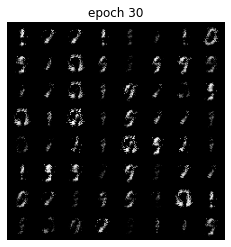

Epoch 30 of 100
Generator loss: 1.50084247, Discriminator loss: 1.04041998


118it [00:33,  3.47it/s]


Epoch 31 of 100
Generator loss: 1.52457421, Discriminator loss: 1.05033167


118it [00:34,  3.39it/s]


Epoch 32 of 100
Generator loss: 1.42425960, Discriminator loss: 1.07301531


118it [00:34,  3.39it/s]


Epoch 33 of 100
Generator loss: 1.56999219, Discriminator loss: 1.04216862


118it [00:34,  3.44it/s]


Epoch 34 of 100
Generator loss: 1.54923080, Discriminator loss: 1.02053751


118it [00:35,  3.35it/s]


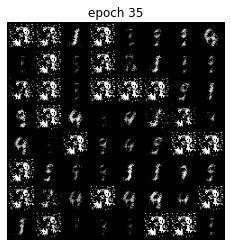

Epoch 35 of 100
Generator loss: 1.55457998, Discriminator loss: 0.99067891


118it [00:34,  3.39it/s]


Epoch 36 of 100
Generator loss: 1.56958013, Discriminator loss: 1.00818428


118it [00:34,  3.41it/s]


Epoch 37 of 100
Generator loss: 1.58667862, Discriminator loss: 1.01600382


118it [00:33,  3.48it/s]


Epoch 38 of 100
Generator loss: 1.50800436, Discriminator loss: 1.04868667


118it [00:34,  3.39it/s]


Epoch 39 of 100
Generator loss: 1.48415466, Discriminator loss: 1.01765203


118it [00:34,  3.46it/s]


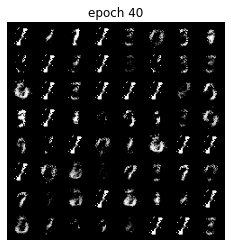

Epoch 40 of 100
Generator loss: 1.57876423, Discriminator loss: 0.98358914


118it [00:34,  3.41it/s]


Epoch 41 of 100
Generator loss: 1.58344223, Discriminator loss: 0.98206011


118it [00:34,  3.44it/s]


Epoch 42 of 100
Generator loss: 1.56262866, Discriminator loss: 1.00853086


118it [00:35,  3.30it/s]


Epoch 43 of 100
Generator loss: 1.56094142, Discriminator loss: 1.01083944


118it [00:34,  3.39it/s]


Epoch 44 of 100
Generator loss: 1.53515090, Discriminator loss: 1.01526885


118it [00:34,  3.43it/s]


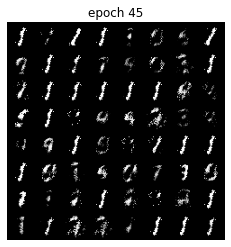

Epoch 45 of 100
Generator loss: 1.54553900, Discriminator loss: 0.99704942


118it [00:34,  3.40it/s]


Epoch 46 of 100
Generator loss: 1.51178309, Discriminator loss: 1.02486256


118it [00:33,  3.49it/s]


Epoch 47 of 100
Generator loss: 1.47265987, Discriminator loss: 1.03343486


118it [00:34,  3.41it/s]


Epoch 48 of 100
Generator loss: 1.48813920, Discriminator loss: 1.01400829


118it [00:33,  3.48it/s]


Epoch 49 of 100
Generator loss: 1.44235833, Discriminator loss: 1.03303359


118it [00:34,  3.42it/s]


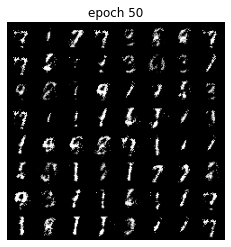

Epoch 50 of 100
Generator loss: 1.46347557, Discriminator loss: 1.03172842


118it [00:34,  3.38it/s]


Epoch 51 of 100
Generator loss: 1.43417456, Discriminator loss: 1.04386615


118it [00:35,  3.30it/s]


Epoch 52 of 100
Generator loss: 1.50524556, Discriminator loss: 1.01825160


118it [00:34,  3.44it/s]


Epoch 53 of 100
Generator loss: 1.46905455, Discriminator loss: 1.02587832


118it [00:34,  3.39it/s]


Epoch 54 of 100
Generator loss: 1.53190645, Discriminator loss: 1.00724024


118it [00:34,  3.44it/s]


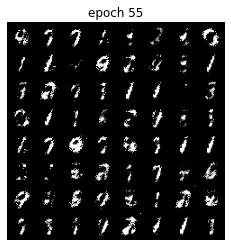

Epoch 55 of 100
Generator loss: 1.46320838, Discriminator loss: 1.05991533


118it [00:35,  3.37it/s]


Epoch 56 of 100
Generator loss: 1.44803376, Discriminator loss: 1.05089987


118it [00:34,  3.44it/s]


Epoch 57 of 100
Generator loss: 1.47110786, Discriminator loss: 1.04003107


118it [00:35,  3.33it/s]


Epoch 58 of 100
Generator loss: 1.46245869, Discriminator loss: 1.05481880


118it [00:34,  3.39it/s]


Epoch 59 of 100
Generator loss: 1.39867312, Discriminator loss: 1.06099480


118it [00:35,  3.37it/s]


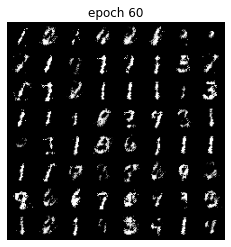

Epoch 60 of 100
Generator loss: 1.44651168, Discriminator loss: 1.03112548


118it [00:35,  3.37it/s]


Epoch 61 of 100
Generator loss: 1.42002220, Discriminator loss: 1.05428349


118it [00:34,  3.46it/s]


Epoch 62 of 100
Generator loss: 1.40608607, Discriminator loss: 1.06308031


118it [00:36,  3.27it/s]


Epoch 63 of 100
Generator loss: 1.43318094, Discriminator loss: 1.04479271


118it [00:36,  3.27it/s]


Epoch 64 of 100
Generator loss: 1.37436102, Discriminator loss: 1.06382821


118it [00:35,  3.29it/s]


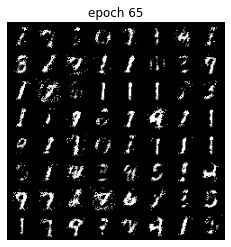

Epoch 65 of 100
Generator loss: 1.39421896, Discriminator loss: 1.07291510


118it [00:35,  3.29it/s]


Epoch 66 of 100
Generator loss: 1.39426203, Discriminator loss: 1.05926686


118it [00:35,  3.36it/s]


Epoch 67 of 100
Generator loss: 1.39658794, Discriminator loss: 1.08522726


118it [00:34,  3.39it/s]


Epoch 68 of 100
Generator loss: 1.33189935, Discriminator loss: 1.09254993


118it [00:34,  3.46it/s]


Epoch 69 of 100
Generator loss: 1.40358589, Discriminator loss: 1.08164794


118it [00:34,  3.42it/s]


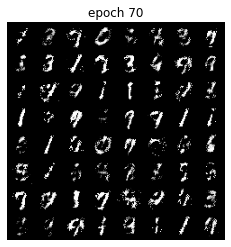

Epoch 70 of 100
Generator loss: 1.38114182, Discriminator loss: 1.08178966


118it [00:34,  3.44it/s]


Epoch 71 of 100
Generator loss: 1.28627375, Discriminator loss: 1.12562948


118it [00:35,  3.32it/s]


Epoch 72 of 100
Generator loss: 1.28878212, Discriminator loss: 1.10588704


118it [00:34,  3.44it/s]


Epoch 73 of 100
Generator loss: 1.34630132, Discriminator loss: 1.07738360


118it [00:35,  3.31it/s]


Epoch 74 of 100
Generator loss: 1.32087471, Discriminator loss: 1.10888339


118it [00:35,  3.31it/s]


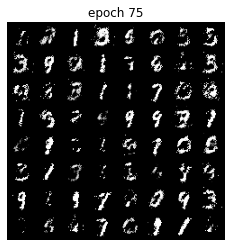

Epoch 75 of 100
Generator loss: 1.33268632, Discriminator loss: 1.09936725


118it [00:34,  3.44it/s]


Epoch 76 of 100
Generator loss: 1.31492436, Discriminator loss: 1.11028987


118it [00:34,  3.40it/s]


Epoch 77 of 100
Generator loss: 1.31357812, Discriminator loss: 1.10130403


118it [00:34,  3.46it/s]


Epoch 78 of 100
Generator loss: 1.33232270, Discriminator loss: 1.09183715


118it [00:35,  3.29it/s]


Epoch 79 of 100
Generator loss: 1.30983168, Discriminator loss: 1.10154193


118it [00:34,  3.46it/s]


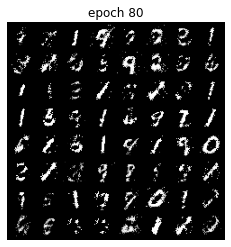

Epoch 80 of 100
Generator loss: 1.29806716, Discriminator loss: 1.11572377


118it [00:35,  3.31it/s]


Epoch 81 of 100
Generator loss: 1.31727755, Discriminator loss: 1.10807031


118it [00:34,  3.44it/s]


Epoch 82 of 100
Generator loss: 1.31558807, Discriminator loss: 1.09704008


118it [00:35,  3.35it/s]


Epoch 83 of 100
Generator loss: 1.36295593, Discriminator loss: 1.08226564


118it [00:34,  3.42it/s]


Epoch 84 of 100
Generator loss: 1.38400969, Discriminator loss: 1.07111121


118it [00:33,  3.48it/s]


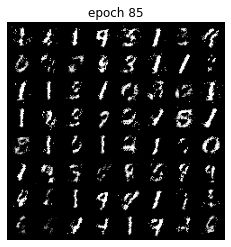

Epoch 85 of 100
Generator loss: 1.31507530, Discriminator loss: 1.10379157


118it [00:35,  3.34it/s]


Epoch 86 of 100
Generator loss: 1.28113631, Discriminator loss: 1.10405315


118it [00:33,  3.50it/s]


Epoch 87 of 100
Generator loss: 1.34452091, Discriminator loss: 1.08834661


118it [00:34,  3.43it/s]


Epoch 88 of 100
Generator loss: 1.32528565, Discriminator loss: 1.09154445


118it [00:34,  3.39it/s]


Epoch 89 of 100
Generator loss: 1.30831670, Discriminator loss: 1.10784096


118it [00:35,  3.36it/s]


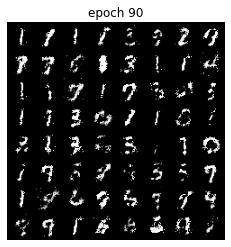

Epoch 90 of 100
Generator loss: 1.28540207, Discriminator loss: 1.11349794


118it [00:34,  3.45it/s]


Epoch 91 of 100
Generator loss: 1.31735987, Discriminator loss: 1.10163792


118it [00:34,  3.40it/s]


Epoch 92 of 100
Generator loss: 1.32238836, Discriminator loss: 1.10219108


118it [00:33,  3.50it/s]


Epoch 93 of 100
Generator loss: 1.31145068, Discriminator loss: 1.11883052


118it [00:34,  3.42it/s]


Epoch 94 of 100
Generator loss: 1.33911953, Discriminator loss: 1.11452373


118it [00:34,  3.42it/s]


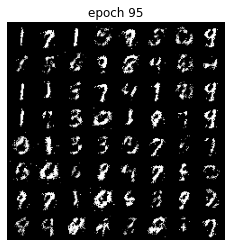

Epoch 95 of 100
Generator loss: 1.36551194, Discriminator loss: 1.09327086


118it [00:33,  3.47it/s]


Epoch 96 of 100
Generator loss: 1.29192526, Discriminator loss: 1.11559945


118it [00:35,  3.35it/s]


Epoch 97 of 100
Generator loss: 1.28301189, Discriminator loss: 1.11887874


118it [00:34,  3.39it/s]


Epoch 98 of 100
Generator loss: 1.26018739, Discriminator loss: 1.13062794


118it [00:34,  3.39it/s]


Epoch 99 of 100
Generator loss: 1.30838012, Discriminator loss: 1.10517846


118it [00:33,  3.47it/s]


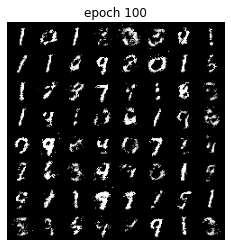

Epoch 100 of 100
Generator loss: 1.27466208, Discriminator loss: 1.11152049


118it [00:35,  3.34it/s]


Epoch 101 of 100
Generator loss: 1.29676773, Discriminator loss: 1.12264831


118it [00:34,  3.43it/s]


Epoch 102 of 100
Generator loss: 1.21486887, Discriminator loss: 1.14719242


118it [00:35,  3.33it/s]


Epoch 103 of 100
Generator loss: 1.20889838, Discriminator loss: 1.14484407


118it [00:35,  3.35it/s]


Epoch 104 of 100
Generator loss: 1.27387472, Discriminator loss: 1.14185461


118it [00:34,  3.41it/s]


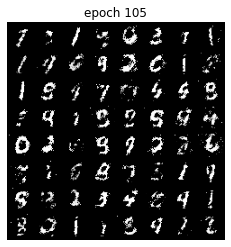

Epoch 105 of 100
Generator loss: 1.24180825, Discriminator loss: 1.15085160


118it [00:36,  3.20it/s]


Epoch 106 of 100
Generator loss: 1.28427092, Discriminator loss: 1.12480498


118it [00:36,  3.25it/s]


Epoch 107 of 100
Generator loss: 1.23147983, Discriminator loss: 1.14389848


118it [00:37,  3.16it/s]


Epoch 108 of 100
Generator loss: 1.23285126, Discriminator loss: 1.13536963


118it [00:37,  3.15it/s]


Epoch 109 of 100
Generator loss: 1.19558631, Discriminator loss: 1.15849959


118it [00:35,  3.30it/s]


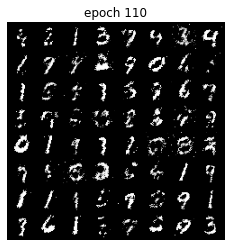

Epoch 110 of 100
Generator loss: 1.17164034, Discriminator loss: 1.16251204


118it [00:36,  3.23it/s]


Epoch 111 of 100
Generator loss: 1.17402434, Discriminator loss: 1.17229160


118it [00:36,  3.22it/s]


Epoch 112 of 100
Generator loss: 1.21937888, Discriminator loss: 1.15568836


118it [00:36,  3.24it/s]


Epoch 113 of 100
Generator loss: 1.19391291, Discriminator loss: 1.15652374


118it [00:35,  3.37it/s]


Epoch 114 of 100
Generator loss: 1.24208835, Discriminator loss: 1.13934955


118it [00:35,  3.30it/s]


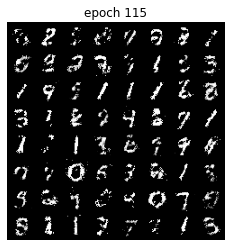

Epoch 115 of 100
Generator loss: 1.23728711, Discriminator loss: 1.14347552


118it [00:35,  3.30it/s]


Epoch 116 of 100
Generator loss: 1.22988372, Discriminator loss: 1.14371199


118it [00:34,  3.42it/s]


Epoch 117 of 100
Generator loss: 1.22993869, Discriminator loss: 1.13994312


118it [00:35,  3.34it/s]


Epoch 118 of 100
Generator loss: 1.16602364, Discriminator loss: 1.16986087


118it [00:35,  3.33it/s]


Epoch 119 of 100
Generator loss: 1.15268838, Discriminator loss: 1.17379750


118it [00:35,  3.29it/s]


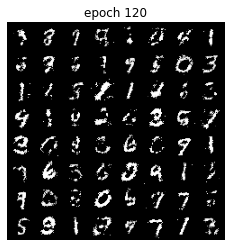

Epoch 120 of 100
Generator loss: 1.14006956, Discriminator loss: 1.19029337


118it [00:35,  3.37it/s]


Epoch 121 of 100
Generator loss: 1.17753208, Discriminator loss: 1.16609945


118it [00:35,  3.30it/s]


Epoch 122 of 100
Generator loss: 1.16660025, Discriminator loss: 1.17440605


118it [00:35,  3.29it/s]


Epoch 123 of 100
Generator loss: 1.27740834, Discriminator loss: 1.13693744


118it [00:34,  3.38it/s]


Epoch 124 of 100
Generator loss: 1.19052638, Discriminator loss: 1.15602516


118it [00:35,  3.31it/s]


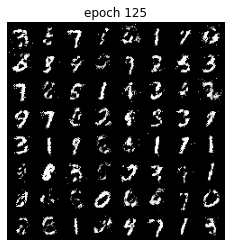

Epoch 125 of 100
Generator loss: 1.22742410, Discriminator loss: 1.15296939


118it [00:34,  3.40it/s]


Epoch 126 of 100
Generator loss: 1.24689666, Discriminator loss: 1.13092475


118it [00:35,  3.28it/s]


Epoch 127 of 100
Generator loss: 1.17188074, Discriminator loss: 1.16430806


118it [00:35,  3.34it/s]


Epoch 128 of 100
Generator loss: 1.18201438, Discriminator loss: 1.16610702


118it [00:35,  3.36it/s]


Epoch 129 of 100
Generator loss: 1.20284725, Discriminator loss: 1.15448047


118it [00:35,  3.37it/s]


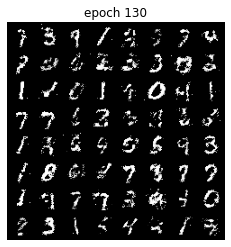

Epoch 130 of 100
Generator loss: 1.21253331, Discriminator loss: 1.14261757


118it [00:34,  3.42it/s]


Epoch 131 of 100
Generator loss: 1.18990755, Discriminator loss: 1.16243837


118it [00:35,  3.33it/s]


Epoch 132 of 100
Generator loss: 1.19739120, Discriminator loss: 1.16180682


118it [00:34,  3.43it/s]


Epoch 133 of 100
Generator loss: 1.19604025, Discriminator loss: 1.15786042


118it [00:35,  3.33it/s]


Epoch 134 of 100
Generator loss: 1.17643240, Discriminator loss: 1.16690857


118it [00:35,  3.35it/s]


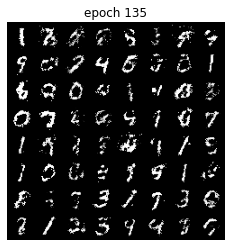

Epoch 135 of 100
Generator loss: 1.16028475, Discriminator loss: 1.17451519


118it [00:35,  3.29it/s]


Epoch 136 of 100
Generator loss: 1.12109615, Discriminator loss: 1.19349603


118it [00:34,  3.44it/s]


Epoch 137 of 100
Generator loss: 1.17403248, Discriminator loss: 1.16727154


118it [00:35,  3.33it/s]


Epoch 138 of 100
Generator loss: 1.18435602, Discriminator loss: 1.16559939


118it [00:35,  3.35it/s]


Epoch 139 of 100
Generator loss: 1.17018235, Discriminator loss: 1.17265918


118it [00:34,  3.44it/s]


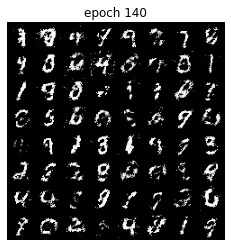

Epoch 140 of 100
Generator loss: 1.15330186, Discriminator loss: 1.17329181


118it [00:35,  3.35it/s]


Epoch 141 of 100
Generator loss: 1.13687047, Discriminator loss: 1.18900982


118it [00:35,  3.35it/s]


Epoch 142 of 100
Generator loss: 1.15917525, Discriminator loss: 1.17905633


118it [00:36,  3.26it/s]


Epoch 143 of 100
Generator loss: 1.14749812, Discriminator loss: 1.17800949


118it [00:34,  3.42it/s]


Epoch 144 of 100
Generator loss: 1.14299735, Discriminator loss: 1.18254341


118it [00:34,  3.47it/s]


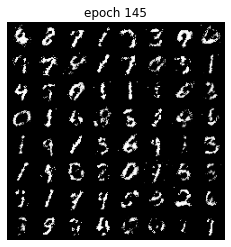

Epoch 145 of 100
Generator loss: 1.11092231, Discriminator loss: 1.19130366


118it [00:33,  3.49it/s]


Epoch 146 of 100
Generator loss: 1.13211293, Discriminator loss: 1.17966082


118it [00:33,  3.51it/s]


Epoch 147 of 100
Generator loss: 1.14298316, Discriminator loss: 1.18054800


118it [00:34,  3.38it/s]


Epoch 148 of 100
Generator loss: 1.15252399, Discriminator loss: 1.17508302


118it [00:36,  3.26it/s]


Epoch 149 of 100
Generator loss: 1.11948693, Discriminator loss: 1.18871772


118it [00:34,  3.45it/s]


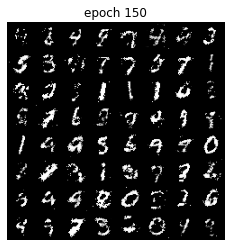

Epoch 150 of 100
Generator loss: 1.14601675, Discriminator loss: 1.18199444


118it [00:35,  3.31it/s]


Epoch 151 of 100
Generator loss: 1.10137606, Discriminator loss: 1.19609946


118it [00:34,  3.38it/s]


Epoch 152 of 100
Generator loss: 1.10326455, Discriminator loss: 1.20651203


118it [00:35,  3.37it/s]


Epoch 153 of 100
Generator loss: 1.11582388, Discriminator loss: 1.20068915


118it [00:35,  3.29it/s]


Epoch 154 of 100
Generator loss: 1.12376458, Discriminator loss: 1.19217185


118it [00:34,  3.38it/s]


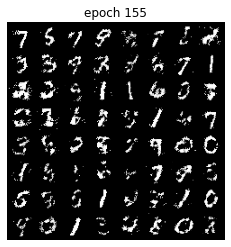

Epoch 155 of 100
Generator loss: 1.08964042, Discriminator loss: 1.20538868


118it [00:35,  3.35it/s]


Epoch 156 of 100
Generator loss: 1.08768574, Discriminator loss: 1.20725291


118it [00:35,  3.34it/s]


Epoch 157 of 100
Generator loss: 1.07907628, Discriminator loss: 1.21556000


118it [00:35,  3.29it/s]


Epoch 158 of 100
Generator loss: 1.09519514, Discriminator loss: 1.21266684


118it [00:34,  3.42it/s]


Epoch 159 of 100
Generator loss: 1.13478837, Discriminator loss: 1.17286045


118it [00:34,  3.37it/s]


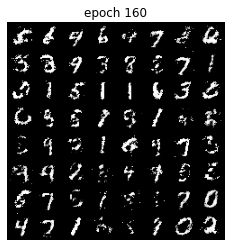

Epoch 160 of 100
Generator loss: 1.14828960, Discriminator loss: 1.18374472


118it [00:34,  3.39it/s]


Epoch 161 of 100
Generator loss: 1.10452746, Discriminator loss: 1.19376549


118it [00:35,  3.31it/s]


Epoch 162 of 100
Generator loss: 1.10131468, Discriminator loss: 1.19675607


118it [00:35,  3.35it/s]


Epoch 163 of 100
Generator loss: 1.11599784, Discriminator loss: 1.18843323


118it [00:35,  3.35it/s]


Epoch 164 of 100
Generator loss: 1.08864494, Discriminator loss: 1.20180278


118it [00:35,  3.35it/s]


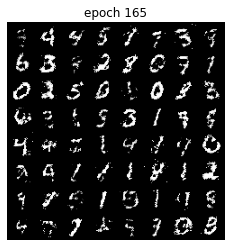

Epoch 165 of 100
Generator loss: 1.13640601, Discriminator loss: 1.18549519


118it [00:35,  3.30it/s]


Epoch 166 of 100
Generator loss: 1.11394877, Discriminator loss: 1.18484316


118it [00:35,  3.37it/s]


Epoch 167 of 100
Generator loss: 1.09579343, Discriminator loss: 1.20398155


118it [00:35,  3.37it/s]


Epoch 168 of 100
Generator loss: 1.10726524, Discriminator loss: 1.19216328


118it [00:34,  3.41it/s]


Epoch 169 of 100
Generator loss: 1.10218829, Discriminator loss: 1.19919732


118it [00:35,  3.35it/s]


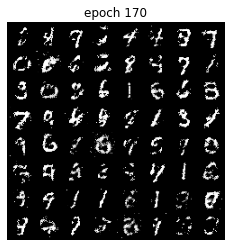

Epoch 170 of 100
Generator loss: 1.12663400, Discriminator loss: 1.19011009


118it [00:34,  3.42it/s]


Epoch 171 of 100
Generator loss: 1.11876860, Discriminator loss: 1.19208597


118it [00:35,  3.30it/s]


Epoch 172 of 100
Generator loss: 1.11974368, Discriminator loss: 1.19163290


118it [00:35,  3.36it/s]


Epoch 173 of 100
Generator loss: 1.13838769, Discriminator loss: 1.18778009


118it [00:35,  3.36it/s]


Epoch 174 of 100
Generator loss: 1.12880128, Discriminator loss: 1.18240431


118it [00:34,  3.39it/s]


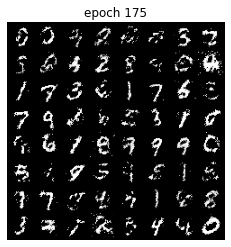

Epoch 175 of 100
Generator loss: 1.15740221, Discriminator loss: 1.17236638


118it [00:34,  3.42it/s]


Epoch 176 of 100
Generator loss: 1.12659702, Discriminator loss: 1.18469359


118it [00:34,  3.41it/s]


Epoch 177 of 100
Generator loss: 1.12048425, Discriminator loss: 1.19307760


118it [00:33,  3.49it/s]


Epoch 178 of 100
Generator loss: 1.15880332, Discriminator loss: 1.16500850


118it [00:34,  3.39it/s]


Epoch 179 of 100
Generator loss: 1.13495596, Discriminator loss: 1.18464362


118it [00:34,  3.42it/s]


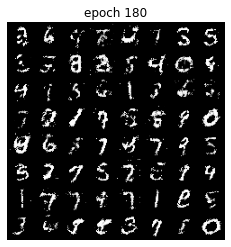

Epoch 180 of 100
Generator loss: 1.13306190, Discriminator loss: 1.17845650


118it [00:35,  3.34it/s]


Epoch 181 of 100
Generator loss: 1.14536408, Discriminator loss: 1.18933474


118it [00:33,  3.48it/s]


Epoch 182 of 100
Generator loss: 1.12334819, Discriminator loss: 1.19385483


118it [00:34,  3.40it/s]


Epoch 183 of 100
Generator loss: 1.12269091, Discriminator loss: 1.17659093


118it [00:34,  3.41it/s]


Epoch 184 of 100
Generator loss: 1.10466692, Discriminator loss: 1.19292888


118it [00:33,  3.49it/s]


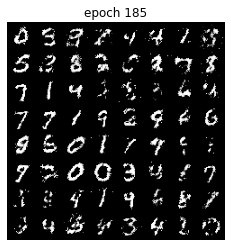

Epoch 185 of 100
Generator loss: 1.04693726, Discriminator loss: 1.21522497


118it [00:34,  3.39it/s]


Epoch 186 of 100
Generator loss: 1.06056681, Discriminator loss: 1.21634519


118it [00:34,  3.39it/s]


Epoch 187 of 100
Generator loss: 1.05746683, Discriminator loss: 1.21408178


118it [00:35,  3.32it/s]


Epoch 188 of 100
Generator loss: 1.04788021, Discriminator loss: 1.22355406


118it [00:34,  3.37it/s]


Epoch 189 of 100
Generator loss: 1.06073392, Discriminator loss: 1.22648674


118it [00:34,  3.47it/s]


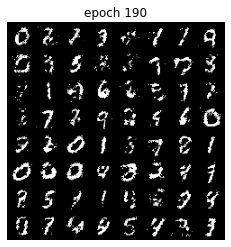

Epoch 190 of 100
Generator loss: 1.09211702, Discriminator loss: 1.20896892


118it [00:34,  3.39it/s]


Epoch 191 of 100
Generator loss: 1.10566698, Discriminator loss: 1.19728862


118it [00:34,  3.44it/s]


Epoch 192 of 100
Generator loss: 1.09110129, Discriminator loss: 1.19438884


118it [00:34,  3.39it/s]


Epoch 193 of 100
Generator loss: 1.07614589, Discriminator loss: 1.21676184


118it [00:34,  3.37it/s]


Epoch 194 of 100
Generator loss: 1.04859453, Discriminator loss: 1.22492552


118it [00:34,  3.38it/s]


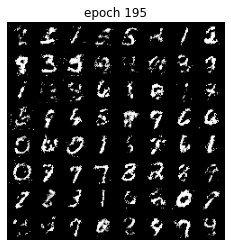

Epoch 195 of 100
Generator loss: 1.08017731, Discriminator loss: 1.21466679


118it [00:34,  3.37it/s]


Epoch 196 of 100
Generator loss: 1.15281511, Discriminator loss: 1.17898021


118it [00:35,  3.36it/s]


Epoch 197 of 100
Generator loss: 1.10564398, Discriminator loss: 1.20282706


118it [00:35,  3.36it/s]


Epoch 198 of 100
Generator loss: 1.10183869, Discriminator loss: 1.20417970


118it [00:34,  3.45it/s]


Epoch 199 of 100
Generator loss: 1.13332833, Discriminator loss: 1.18218744


118it [00:34,  3.40it/s]


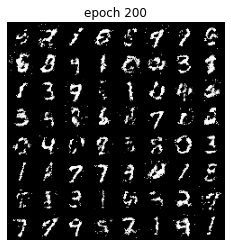

Epoch 200 of 100
Generator loss: 1.09233663, Discriminator loss: 1.19979128


118it [00:34,  3.46it/s]


Epoch 201 of 100
Generator loss: 1.12170077, Discriminator loss: 1.18162961


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return criterion(output, true_label)
    
    
    ######################################
    
def discriminator_loss(output, true_label):
    return criterion(output, true_label)
    
    
    ######################################
    
k = 1
for epoch in range(201):
    loss_g = 0.0
    loss_d = 0.0
    counter = 0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        real_images = data[0]
        fake_images = generator(noise)

        for i in range(k):
            optim_d.zero_grad()
            fake_images = generator(noise)
            true_predictions = discriminator(real_images)
            false_predictions = discriminator(fake_images)
            discriminator_loss_real = discriminator_loss(true_predictions, label_real(real_images.size(0)))
            discriminator_loss_fake = discriminator_loss(false_predictions, label_fake(fake_images.size(0)))
            discriminator_loss_real.backward()
            discriminator_loss_fake.backward()
            loss_d += discriminator_loss_real.item() + discriminator_loss_fake.item()
            optim_d.step()    
        
        ##GENERATOR:
        fake_images = generator(noise)
        optim_g.zero_grad()
        prediction = discriminator(fake_images)
        generator_loss_fake = generator_loss(prediction, label_real(fake_images.size(0)))
        generator_loss_fake.backward()
        optim_g.step()
        
        
        ##Print loss
        loss_g += generator_loss_fake.item()
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0 or epoch == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('./generator_images.gif', imgs)

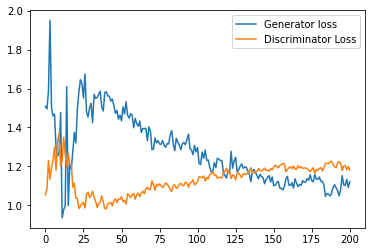

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g., label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

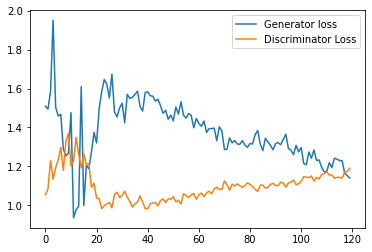

In [20]:
plt.figure()
plt.plot(losses_g[:120], label='Generator loss')
plt.plot(losses_d[:120], label='Discriminator Loss')
plt.legend()
plt.savefig('./loss.png')